# Project: Investigate a Dataset (Medical Appointment No Shows Analysis)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> A person makes a doctor appointment, receives all the instructions and no-show. Who to blame?

> In this analysis, we are going to dive deeper into a dataset trying to find an answer for this question.
>
>The dataset we are going to explore collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row. The dataset includes 14 columns with different features.
Which makes us very curious to know what features most affect the no-show incident. Is it the gender? the time between the reservation and actual appointment time? the day in which the appointment is scheduled? are there specific users with high No-Show %?, let's start the analysis and find the answer! 

# Our Dataset:

Here is the definition of the columns we are going to explore,

01 - PatientId:
Identification of a patient

02 - AppointmentID:
Identification of each appointment

03 - Gender:
Male or Female . Female is the greater proportion, woman takes way more care of their health in comparison to man.

04 - ScheduledDay:
The day of the actual appointment, when they have to visit the doctor.

05 - AppointmentDay:
The day someone called or registered the appointment, this is before appointment of course.

06 - Age:
How old is the patient.

07 - Neighbourhood:
Where the appointment takes place.

08 - Scholarship:
True of False. (whether or not the patient is enrolled in Brasilian welfare program Bolsa Família).
More details here https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia

09 - Hipertension:
True or False

10 - Diabetes:
True or False

11 - Alcoholism:
True or False

12 - Handcap:
True or False

13 - SMS_received:
1 or more messages sent to the patient.

14 - No-show:
True or False.

Regarding the encoding of the last column: it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.

In [1]:
# First, Let's import all libraries we will use in our analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

In [2]:
# Let's now load our data csv file,
df=pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

# Let's check what does the data look like.
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
# Now let's explore the data to know more details about the data types and if there are any missing values,

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [4]:
# Great! It seems that there aren't any missing values. 
# Now let's check if there are any duplicated values,

df.duplicated().sum()

0

In [5]:
# Excellent! All data rows are unique.
# So let's check the number of unique values in each column,

df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

### Cleaning our data

It might be interesting to dive deeper in the 2 columns including both schedule and appointment dates. So let's prepare them for analysis by changing the data type to date time format, splitting the date from time and specifying in which day of the week the schedule dates are.

Another thing that caught my attention is that the unique values in the 'Handcap' columns are 5, while the column definition
says it's a True or False column. So we need to dig deeper and check what these extra values are.

Finally, by reading the note regarding the encoding of the last column, the values are ‘No’ if the patient showed up to their
appointment, and ‘Yes’ if they did not show up, which is confusing. It might be important to change these
values to more readable values to avoid confusion. Let's replace 'No' with 'Attended', and 'Yes' with 'Absent'.

In [6]:
# First, Let's start by adding a new column to determine which day of the week is the schedule day:

df['Scheduled_DOW']=pd.to_datetime(df['ScheduledDay']).dt.weekday_name
df['Scheduled_DOW'].head()

0    Friday
1    Friday
2    Friday
3    Friday
4    Friday
Name: Scheduled_DOW, dtype: object

In [7]:
# Then we can change the format of the 2 original data columns and keep the date only without the time:

df['ScheduledDay']=pd.to_datetime(df['ScheduledDay']).dt.date
df['AppointmentDay']=pd.to_datetime(df['AppointmentDay']).dt.date

# Now let's create a new column that calculates the number of days between the schedule date and appointment date,
df['#Days']=(df['AppointmentDay']-df['ScheduledDay'])

# Let's change the format of the values to be integar instead of time delta,
df['#Days']=df['#Days'].apply(lambda x: x.days)

# Now let's have a look on our dataset
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled_DOW,#Days
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Friday,0
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,Friday,0
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,Friday,0
3,8.679512e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,Friday,0
4,8.841186e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,Friday,0


In [8]:
# let's check the unique values of # of days,
df['#Days'].unique()

array([  0,   2,   3,   1,   4,   9,  29,  10,  23,  11,  18,  17,  14,
        28,  24,  21,  15,  16,  22,  43,  30,  31,  42,  32,  56,  45,
        46,  39,  37,  38,  44,  50,  60,  52,  53,  65,  67,  91,  66,
        84,  78,  87, 115, 109,  63,  70,  72,  57,  58,  51,  59,  41,
        49,  73,  64,  20,  33,  34,   6,  35,  36,  12,  13,  40,  47,
         8,   5,   7,  25,  26,  48,  27,  19,  61,  55,  62, 176,  54,
        77,  69,  83,  76,  89,  81, 103,  79,  68,  75,  85, 112,  -1,
        80,  86,  98,  94, 142, 155, 162, 169, 104, 133, 125,  96,  88,
        90, 151, 126, 127, 111, 119,  74,  71,  82, 108, 110, 102, 122,
       101, 105,  92,  97,  93, 107,  95,  -6, 139, 132, 179, 117, 146, 123])

In [9]:
# There are -ve values which must be a mistake, so we need to drop these rows

df.drop(index=df[df['#Days']<0].index, inplace=True)

# Now let's make sure they were all dropped.
np.sum(df['#Days'].unique()<0)

0

In [10]:
# Next, let's check the values in 'Handcap' column:
# Running the below code will return the unique values, 
df['Handcap'].unique()

array([0, 1, 2, 3, 4])

These results are not explained by the column definition (True or False values only), which means we need to go back to the source of our dataset and do further investigation to understand what these values indicate.

By checking kaggle website, the dataset creator JoniHoppen wrote a comment that this should be a binary column, so any values other than 0 & 1 should be ignored. we need to check the number of these entries to decide on whether to drop or keep these records.

In [11]:
df.groupby('Handcap').count()['PatientId']

Handcap
0    108283
1      2040
2       183
3        13
4         3
Name: PatientId, dtype: int64

In [12]:
# it seems that values other than 0 & 1 are small, so we can drop them without worrying about the accuracy of our analysis.
df.drop(index=df[df['Handcap']>1].index, inplace=True)
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled_DOW,#Days
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Friday,0
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,Friday,0
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,Friday,0
3,8.679512e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,Friday,0
4,8.841186e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,Friday,0


In [13]:
# Finally, let's modify the values of the last column to be more readable:

# Running this line will output the unique values to be able to replace them.
pd.unique(df['No-show'])

# Now let's replace the values:
df['No-show']=df['No-show'].map({'No':'Attended', 'Yes': 'Absent' })

# Let's have a look on the new data
df['No-show'].head(10)

0    Attended
1    Attended
2    Attended
3    Attended
4    Attended
5    Attended
6      Absent
7      Absent
8    Attended
9    Attended
Name: No-show, dtype: object

**Now our dataset is ready for investigation. Let's start!**

<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1 (Does the difference in gender affect the no show?)

In [14]:
# let's compare the distribution of genders in both the attended and absent cases,

# let's create a dataset with only our 2 columns of interest,
gndr=df[['Gender','No-show']]

# Now let's pivot the table to know the number of occurances of each case,
gndr_smry=gndr.pivot_table(index='Gender',columns='No-show', aggfunc=len )

# then add a column to calculate the % of attendance for each gender,

gndr_smry['att%']=gndr_smry['Attended']/(gndr_smry['Attended']+gndr_smry['Absent'])
gndr_smry


No-show,Absent,Attended,att%
Gender,,,
F,14565,57163,0.796941
M,7708,30887,0.800285


Well, it seems that both genders have nearly the same % of attendance!

### Research Question 2 (Does the # of days between the schedule and assignment days affect the no show?)

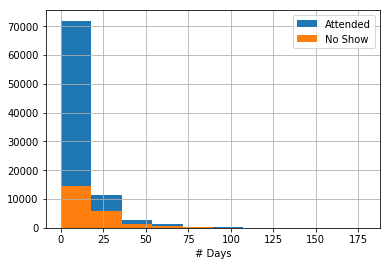

In [15]:
# let's compare the distribution of # of days in both the attended and absent cases,

# First, we are going to created a dataset with the attended appointments,
attended_df=df[df['No-show']=='Attended']['#Days']

# then create another one with the no show cases,
no_show_df=df[df['No-show']=='Absent']['#Days']

# Now let's plot the distribution of both datasets,

attended_df.hist(label='Attended')
no_show_df.hist(label='No Show')

plt.xlabel('# Days')
plt.legend();

Since there are thousands of patients who make the reservation in the same day or the previous day which makes the # of days 0 or 1, the distribution is not quite clear. We can do a log transformation for the data and plot it for a clear view.


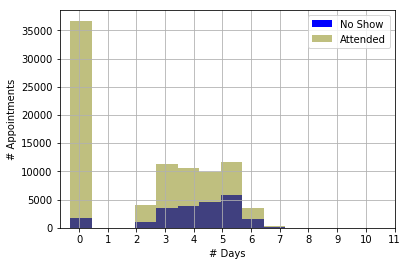

In [16]:
# Since some values are 0, it will return an error of calculating log(0), so i will add a small fraction (0.1) to the values to 
# avoid the error,

# Let's plot the distribution after the transformation,

np.log(no_show_df+0.1).hist(label='No Show', alpha=1, color='blue')
np.log(attended_df+0.1).hist(label='Attended',alpha=0.5, color='olive')

plt.xticks(range(-2,10),range(0,12) )
plt.xlabel('# Days')
plt.ylabel('# Appointments')
plt.legend();

Well, It seems that people who reserve the appointment in the same day or the previous day tend to attend, while the distribution of people who reserve the appointment long time before the schedule date vary between attending and being no-show. 

The high no show that happens in long durations might be because patients forgot about their appointments. This might suggest coming up with solutions to remind people of their appointments if they reserve it long before the schedule date.

### Research Question 3  (Does the day of week in which the appointment is scheduled affect the No-show %?)

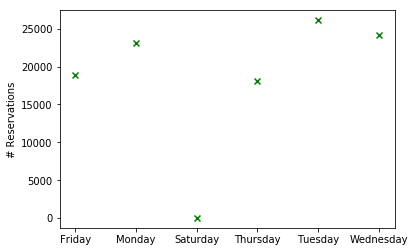

In [17]:
# First, Let's take a look at the number of appointments in each week day to know which day has the highest # of schedules.

# We will group by the day of week to get the total per day,
days=df.groupby('Scheduled_DOW').agg(len).iloc[:,1]

# Now let's do a scatter plot to display the result
plt.scatter(x=days.index, y=days, marker = 'x', color='green')
plt.ylabel('# Reservations');

In [18]:
# Well it seems that Tuesday has the highest # of schedules.

# let's pivot the Day of Week and return the number of attendees and absence for each day to calculate the absence %
ab_ratio=df.pivot_table(index='Scheduled_DOW', columns='No-show',aggfunc=len)['#Days']

# then we can calculate the % of absence for each day
ab_ratio['Attendance%']=np.round(ab_ratio['Attended']*100/(ab_ratio['Attended']+ab_ratio['Absent']))
ab_ratio

No-show,Absent,Attended,Attendance%
Scheduled_DOW,,,
Friday,3881,15000,79.0
Monday,4552,18493,80.0
Saturday,1,23,96.0
Thursday,3695,14348,80.0
Tuesday,5276,20834,80.0
Wednesday,4868,19352,80.0


It seems the absence ratio is nearly the same in all week days, we can ignore the figures of Saturday since they are very small compared to other days.

### Research Question 4 (Are there specific users with high absence %?)

In [19]:
# First question to ask, what is the overall no_show%?

n_s_avg=round(np.sum(df['No-show']=='Absent')/(np.sum(df['No-show']=='Absent')+np.sum(df['No-show']=='Attended')),1)
n_s_avg

0.20000000000000001

In [20]:
# Now let's explore the number of appointments per user along with the no-show status:

absen=df[['PatientId','No-show']].pivot_table(columns='No-show', index=df['PatientId'], aggfunc='count')
absen.reset_index(inplace=True)

# then replace the Nan with 0 to facilitate our calculations,
absen.iloc[:,1]=absen.iloc[:,1].replace(np.nan,0)

# Let's add a column summing both No-show cases,
absen['total']=absen.iloc[:,1]+absen.iloc[:,2]


# Now we will add a column with the absence% (rounded figure):
absen['no-show%']=round(absen.iloc[:,1]*100/(absen.iloc[:,1]+absen.iloc[:,2]))
absen.head()

PatientId                 total no-show%
No-show               Absent Attended               
0         39217.84439    0.0      1.0   1.0      0.0
1         43741.75652    0.0      1.0   1.0      0.0
2         93779.52927    0.0      1.0   1.0      0.0
3        141724.16655    0.0      1.0   1.0      0.0
4        537615.28476    0.0      1.0   1.0      0.0

In [21]:
# Now let's sort descendingly and see people with no-show% above the average:
absen.sort_values(by=('no-show%'),ascending=False, inplace=True)
above=absen[absen['no-show%']>n_s_avg]

# let's also assume we will select patients with # of appointments above a specific # (Assuming it is 5) from the 'above' list,

num=5 # i added the number as a variable name so that it would be easy to change it and check the results,
highest=above[above['total']>num]

# so how many patients fall in this criteria?
len(highest)

1056

In [22]:
# Let's see a more clear representation of this group of people, we need to know the % of these patients out of the total,
# and the contribution of their no show to the total no show.

perc= round(len(highest)*100/len(df),2)

# What is their contribution to the total absence?

cont=round(highest.iloc[:,1].sum()*100/absen.iloc[:,1].sum(),2)

#Let's see the result
(perc, cont)

(0.96, 11.52)

Oh!...Only 1% of the patients make 11.5% of the No-Show figure. I would recommend approaching this group with various communication tools (e-mails, SMS...etc) clarifying that they appear to have a high No-Show % and try to investigate the reasons and come up with a solution.

Finally, Let's take a final look at the relation between binary variables and the No-Show

In [23]:
# First, Let's add a new column with the binary encoding of the 'No-show' column to be with 0 or 1 values,

df['ns_encod']=df['No-show'].map({'Attended':0,'Absent':1})

# then, we will identify the binary columns,

binary=['Scholarship','Hipertension','Diabetes','Alcoholism','Handcap','ns_encod']

df[binary].corr()

,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,ns_encod
Scholarship,1.000000,-0.019247,-0.024615,0.035222,-0.009153,0.029424
Hipertension,-0.019247,1.000000,0.432261,0.088084,0.081469,-0.036132
Diabetes,-0.024615,0.432261,1.000000,0.018632,0.054779,-0.015144
Alcoholism,0.035222,0.088084,0.018632,1.000000,0.003143,-0.000228
Handcap,-0.009153,0.081469,0.054779,0.003143,1.000000,-0.008021
ns_encod,0.029424,-0.036132,-0.015144,-0.000228,-0.008021,1.000000


Well, it seems there is not much correlation between the no show and the binary variables.

<a id='conclusions'></a>
## Conclusion

> It seems that there is not much correlation between the gender and the No-Show, also the history of other illnesses or chronic diseases is not the driver for the No-Show. I believe it's a personal behavior that needs to be changed by approaching specific group of people with high no-show trend for further investigation and setting a clear process for handling this issue.
It might be useful also to come up with tools to remind patients of their schedule date in case they reserve it long time before the schedule date.

In [24]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0